# Visualize calendar aging

In [4]:
#Imports
import os
import logging as lg
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Data handling

In [3]:
# Configure logging - alternative: DEBUG, ERROR
lg.basicConfig(level=lg.INFO) 

# Define file paths and constants
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data', 'prepr_res_eoc')

# Define parameters for different categories
calendar_parameters = ["P{:03d}".format(i) for i in range(1, 17)]
cyclic_parameters = ["P{:03d}".format(i) for i in range(17, 65)]
profile_parameters = ["P{:03d}".format(i) for i in range(65, 77)]

# Define color and line style mappings for plots
color_palette = {273.15: "blue", 283.15: "green", 298.15: "darkorange", 313.15: "red"}
line_styles = {0.42: ":", 2.1: "--", 3.78: "-.", 4.2: "-"}

def create_dataframe_from_files(files_to_search):
    """
    This function reads files from 'data_dir' that match the identifiers in 'files_to_search'.
    It extracts specific information from each file and compiles it into a DataFrame.

    Args:
        files_to_search (list): List of file identifiers to include in the DataFrame.

    Returns:
        DataFrame: Compiled data from specified files.
    """

    # List all files in the directory and filter out files that match the search criteria
    all_files = os.listdir(data_dir)
    relevant_files = [f for f in all_files if any(param in f for param in files_to_search)]
    lg.info(f"Found {len(relevant_files)} csv files")
    
    # Iterate over each file that matches the criteria
    data_list = []
    for file in sorted(relevant_files):
        try:
            full_path = os.path.join(data_dir, file)
            # Use regular expressions to extract parameter, slave, and cell numbers from the filename
            p_number, s_number, c_number = re.findall(r'P(\d+)|S(\d+)|C(\d+)', file)[0]
            df = pd.read_csv(full_path, usecols=['age_temp', 'age_soc'], delimiter=';', nrows=1)
            
            # Compile the extracted data into a dictionary
            file_data = {
                'fileName': file,         # Name of the file
                'filePath': full_path,    # Full path to the file
                'SlaveNumber': s_number,  # Extracted slave number
                'CellNumber': c_number,   # Extracted cell number
                'age_temp': df.at[0, 'age_temp'],  # Temperature data from the file
                'age_soc': df.at[0, 'age_soc'],    # State of charge data from the file
                "parameterId": p_number   # Extracted parameter ID
            }
            data_list.append(file_data)
        except Exception as e:
            lg.error(f"Error processing file {file}: {e}")

    # Create a DataFrame from the collected data
    return pd.DataFrame(data_list)

# Example usage
df_cells = create_dataframe_from_files(calendar_parameters)
#print(df_cells.head())

# Data aggregation
df_cell_csv_content = pd.DataFrame()
# Iterate over each row in the dataframe 'df_cells'
for _, row in df_cells.iterrows():
    df_temp = pd.read_csv(row["filePath"], sep=";")
    # Filter: select rows where 'cyc_charged' is 0 and 'cyc_condition' is 2
    df_temp = df_temp.query('cyc_charged == 0 and cyc_condition == 2')
    # Normalize the 'cap_aged_est_Ah' column by dividing by the first row's value in this column
    df_temp['cap_aged_est_Ah'] /= df_temp['cap_aged_est_Ah'].iloc[0]
    # Add the filename and parameter ID to each row for tracking the source of the data
    df_temp['fileName'] = row['fileName']
    df_temp['parameterId'] = row['parameterId']
    df_cell_csv_content = pd.concat([df_cell_csv_content, df_temp], ignore_index=True)
#print(df_cell_csv_content.head())

INFO:root:Found 48 csv files


### Plotting

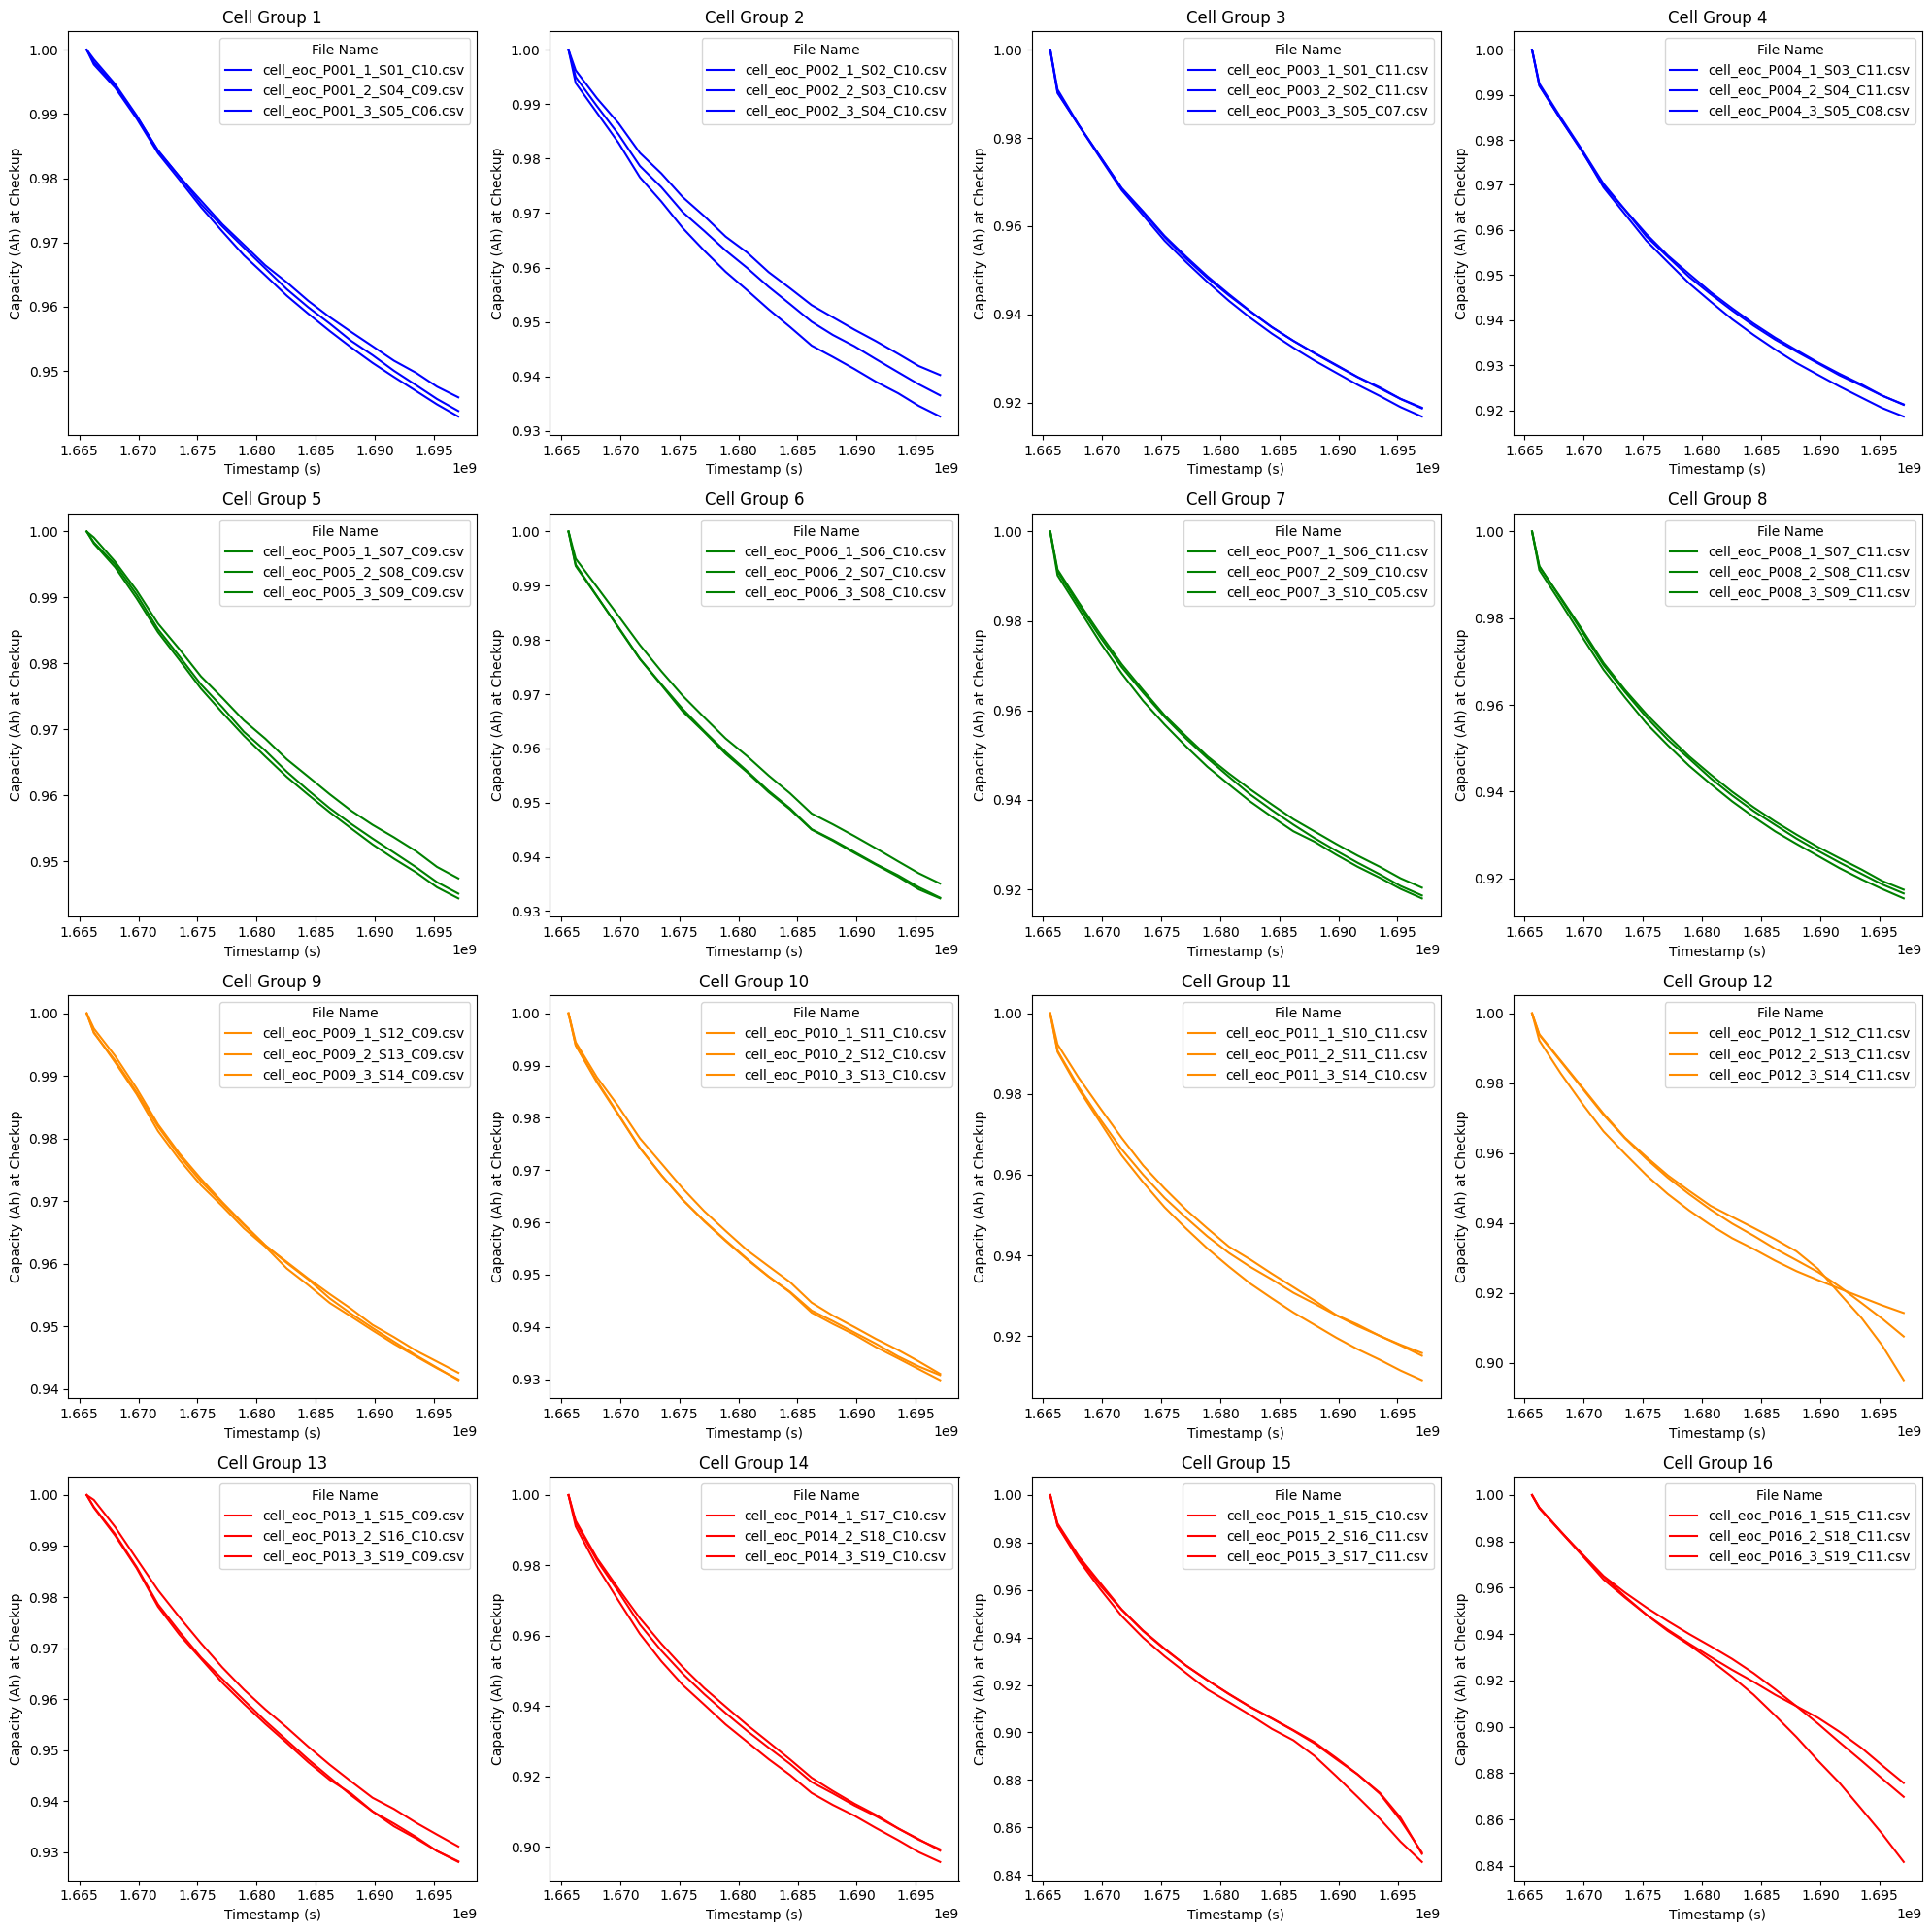

In [12]:
# Parameters for the 4x4 grid
grid_rows = 4
grid_cols = 4

# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=grid_rows, ncols=grid_cols, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Group files into sets of 3 for each subplot
unique_files = df_cell_csv_content["fileName"].unique()
file_groups = [unique_files[i:i + 3] for i in range(0, len(unique_files), 3)]

# Iterate over each group of files and plot in respective subplot
for index, file_group in enumerate(file_groups):
    # Select the appropriate subplot
    ax = axes[index]

    # Iterate through each file in the group and plot its data
    for file in file_group:
        # Filter the dataframe for the current file
        df = df_cell_csv_content.query(f'fileName == "{file}"').reset_index()
        color = color_palette.get(df.at[0, 'age_temp'] + 273.15, 'black')
        
        # Plot the data on the selected subplot and add to the legend
        sns.lineplot(data=df, x="timestamp_s", y="cap_aged_est_Ah", color=color, ax=ax, label=file)
    
    # Add legend to the subplot
    ax.legend(title='File Name')

    # Set labels and titles for each subplot
    ax.set_xlabel("Timestamp (s)")
    ax.set_ylabel("Capacity (Ah) at Checkup")
    ax.set_title(f"Cell Group {index + 1}")

# Hide any unused subplots if the number of groups is less than total subplots
for i in range(len(file_groups), grid_rows * grid_cols):
    axes[i].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
"""# Plotting
plt.figure(figsize=(10, 6))
for file in df_cell_csv_content["fileName"].unique():
    df = df_cell_csv_content.query(f'fileName == "{file}"').reset_index()
    color = color_palette.get(df.at[0, 'age_temp'] + 273.15, 'black')
    sns.lineplot(data=df, x="timestamp_s", y="cap_aged_est_Ah", color=color)

plt.xlabel("Timestamp (s)")
plt.ylabel("Capacity (Ah) at Checkup")
plt.title("Plot of Timestamp vs Capacity")
plt.show()"""
